In [3]:
path1 = ".//Datafiniti_Hotel_Reviews_Jun19.csv"
path2 = ".//Datafiniti_Hotel_Reviews.csv"

In [4]:
import time
start = time.time()
# Import modules
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import pickle

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [5]:
df1 = pd.read_csv(path1)
df1.drop(columns={'reviews.dateAdded'},inplace= True)
df2 = pd.read_csv(path2)
mydata = pd.concat([df1,df2])
mydata.head(3)

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.44178,...,2018-01-03T00:00:00Z,3.0,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,4.0,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.55722,...,2016-10-09T00:00:00Z,3.0,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com


In [8]:
# Important columns. City, Country, and Province columns are excluded because they are not reliable
imp_col_list = ['address', 'name', 'reviews.date', 'reviews.text','reviews.title',
                'reviews.rating','categories','reviews.userProvince','reviews.userCity']
mydatasub = mydata.loc[:,imp_col_list]

In [9]:
# Prep text, add some columns and fillna, and rename columns
mydatasub['reviews.text'] = mydatasub['reviews.text'].str.lower()
mydatasub['reviews.text'] = mydatasub['reviews.text'].replace(to_replace='[^A-Za-z0-9]+', regex=True, value=' ')
mydatasub['reviews.text'] = mydatasub['reviews.text'].fillna('')
mydatasub['review_date'] = pd.to_datetime(mydatasub['reviews.date']).dt.date
mydatasub['review_month'] = pd.to_datetime(mydatasub['reviews.date']).dt.month
mydatasub['words_in_review'] = [len(i.split()) for i in mydatasub['reviews.text']]
season_dict = {1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',
               7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall',12:'Winter'}
mydatasub['review_season'] = mydatasub['review_month'].map(season_dict).fillna('Summer')
mydatasub.rename(columns={'address': 'hotel_address', 'city': 'hotel_city','country':'hotel_country', 
                   'name':'hotel_name'},inplace=True)

In [10]:
mydatasub.head(3)

,hotel_address,hotel_name,reviews.date,reviews.text,reviews.title,reviews.rating,categories,reviews.userProvince,reviews.userCity,review_date,review_month,words_in_review,review_season
0,5620 Calle Real,Best Western Plus South Coast Inn,2018-01-01T00:00:00.000Z,this hotel was nice and quiet did not know the...,Best Western Plus Hotel,3.0,"Hotels,Hotels and motels,Hotel and motel mgmt....",UnitedStates,San Jose,2018-01-01,1,39,Winter
1,5th And San Carlos PO Box 3574,Best Western Carmel's Town House Lodge,2016-04-02T00:00:00Z,we stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,4.0,"Hotels,Lodging,Hotel",CA,San Francisco,2016-04-02,4,62,Spring
2,5th And San Carlos PO Box 3574,Best Western Carmel's Town House Lodge,2016-01-06T00:00:00Z,parking was horrible somebody ran into my rent...,Business,3.0,"Hotels,Lodging,Hotel",AZ,Prescott Valley,2016-01-06,1,55,Winter


In [11]:
import nltk 
from nltk.corpus import stopwords
from string import punctuation

tokenized_review = mydatasub['reviews.text'].apply(lambda row: nltk.word_tokenize(row))
stop_words = set(stopwords.words('english'))
punctuations = set(punctuation)
def remove_stopwords(mylist):
    return [[token for token in myl if token.lower() not in stop_words and token not in punctuations] for myl in mylist ]
filtered_tokens = remove_stopwords(tokenized_review)

In [12]:
decapitalized_tokens = [[word.lower() for word in lists] for lists in filtered_tokens]
only_word = [[word for word in lists if not word.isdigit()] for lists in decapitalized_tokens]


Text(0.5, 1.0, 'Word Frequency Bar Chart')

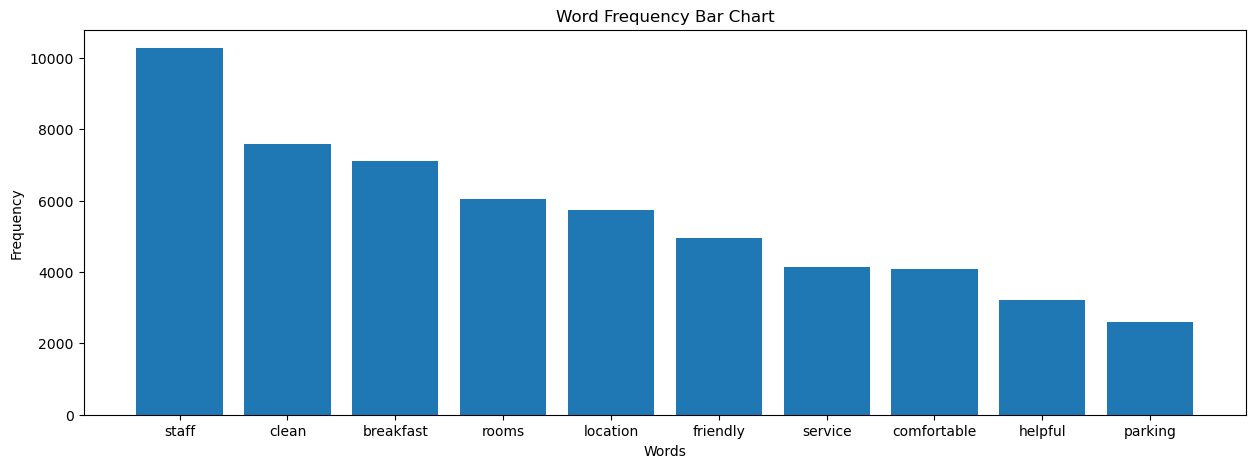

In [81]:
from collections import Counter
flatList = [element for innerList in only_word for element in innerList]
flatList = [element for element in flatList if len(element) > 4]
flatList = [element for element in flatList if element not in ['hotel','front','could','would',
                                                               'stayed','thank','great','night','place','experience',
                                                               'check','really']]
word_counts = Counter(flatList)

top_words = word_counts.most_common(10)

fig = plt.figure(figsize=(15, 5))
plt.bar(dict(top_words).keys(), dict(top_words).values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart')

In [92]:
top_words_list = [tup[0] for tup in top_words]
appear_index = [[i for word in decapitalized_tokens[i] if word in top_words_list]for i in range(len(decapitalized_tokens))]
appear_index_list = [element for innerList in appear_index for element in innerList]
appear_index_list = set(appear_index_list)
appear_index_list

{1,
 2,
 3,
 4,
 10,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 

In [47]:
y = [True if x == 5 else False for x in mydatasub['reviews.rating']]
pd.DataFrame(y).value_counts(normalize=True)

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

reviews_train,reviews_test,y_train,y_test = train_test_split(mydatasub['reviews.text'], y, test_size = .2, stratify = y, random_state = 123)
estimators = [('tfidf', TfidfVectorizer(min_df=5,max_df=0.5)), ('gbc', GradientBoostingClassifier(n_estimators=200))]
pipe_gbc = Pipeline(estimators)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 2)],
    'gbc__max_depth': [2, 2]
}
gs_pipe_gbc = GridSearchCV(pipe_gbc, param_grid=param_grid,cv=2,n_jobs=-1).fit(reviews_train,y_train)
print(gs_pipe_gbc.best_params_)
print(gs_pipe_gbc.best_score_)
print(gs_pipe_gbc.score(reviews_test,y_test).round(2))

KeyboardInterrupt: 

In [ ]:
image.png